In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import seaborn as sns
import system_comparison_plots
%matplotlib inline


In [92]:
spd_pipeline_one = system_comparison_plots.load_spd_pipeline_one()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [39]:
spd_pipeline_one.sort_values("lam_minus_through")

,CV,cost,lam_minus_through,lambda,name,slo,slo_miss_rate,slo_plus_25_per_miss_rate,throughput
94,4.0,5.322,-1.118095,22,SPD-peak_provision,0.35,0.000141,0.000000,23.118095
13,4.0,5.322,-0.785837,26,SPD-peak_provision,0.50,0.000000,0.000000,26.785837
27,4.0,15.966,-0.722993,21,SPD-min_lat_mean_provision,0.50,0.039419,0.016020,21.722993
25,4.0,15.966,-0.722993,21,SPD-min_lat_mean_provision,0.35,0.120321,0.063679,21.722993
29,4.0,15.966,-0.722993,21,SPD-min_lat_mean_provision,1.00,0.000722,0.000080,21.722993
28,4.0,21.288,-0.650928,28,SPD-min_lat_mean_provision,1.00,0.000080,0.000000,28.650928
24,4.0,21.288,-0.650928,28,SPD-min_lat_mean_provision,0.35,0.067657,0.033006,28.650928
26,4.0,21.288,-0.650928,28,SPD-min_lat_mean_provision,0.50,0.018459,0.006059,28.650928
75,1.0,21.288,-0.139593,28,SPD-min_lat_mean_provision,0.50,0.000000,0.000000,28.139593
72,1.0,21.288,-0.139593,28,SPD-min_lat_mean_provision,0.35,0.000000,0.000000,28.139593


In [41]:
ifl_pipeline_one = system_comparison_plots.load_inferline_pipeline_one()

In [42]:
ifl_pipeline_one.sort_values("lam_minus_through")

,CV,cost,lam_minus_through,lambda,name,slo,slo_miss_rate,slo_plus_25_per_miss_rate,throughput,utilization
36,4.0,15.7000,-61.757375,482,InferLine,1.00,0.000000,0.000000,543.757375,0.7
34,4.0,18.2945,-23.811832,670,InferLine,1.00,0.000000,0.000000,693.811832,0.7
40,1.0,13.1055,-23.260641,457,InferLine,1.00,0.000000,0.000000,480.260641,0.7
11,1.0,7.9165,-14.800108,198,InferLine,0.50,0.000000,0.000000,212.800108,0.7
45,1.0,10.5110,-14.084621,334,InferLine,1.00,0.007866,0.000000,348.084621,0.7
42,1.0,18.2945,-13.694312,668,InferLine,1.00,0.000000,0.000000,681.694312,0.7
38,4.0,5.3220,-12.142175,141,InferLine,1.00,0.000000,0.000000,153.142175,0.7
35,4.0,13.1055,-10.706803,448,InferLine,1.00,0.000000,0.000000,458.706803,0.7
3,4.0,5.3220,-6.651726,55,InferLine,0.50,0.000000,0.000000,61.651726,0.7
7,1.0,15.7000,-3.897329,436,InferLine,0.50,0.000000,0.000000,439.897329,0.7


In [43]:
pipeline_one_df = pd.concat([spd_pipeline_one, ifl_pipeline_one])

In [93]:
pipeline_one_df = spd_pipeline_one

# Plot the results

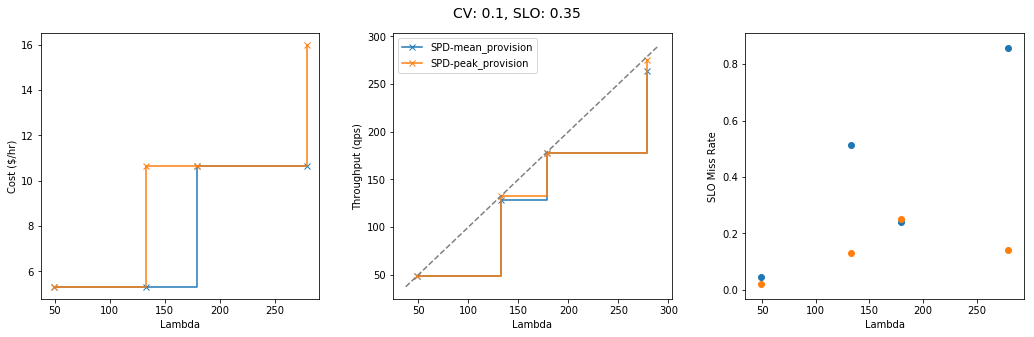

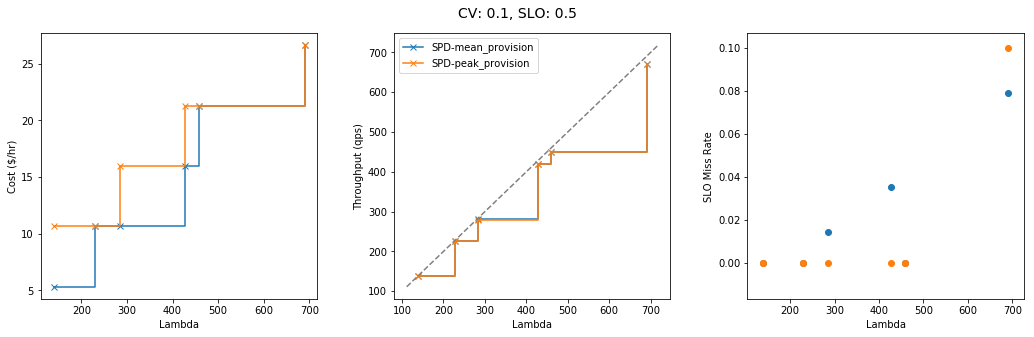

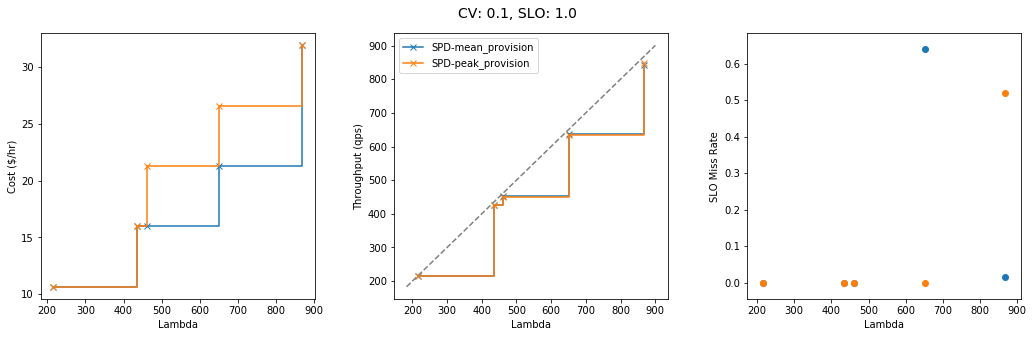

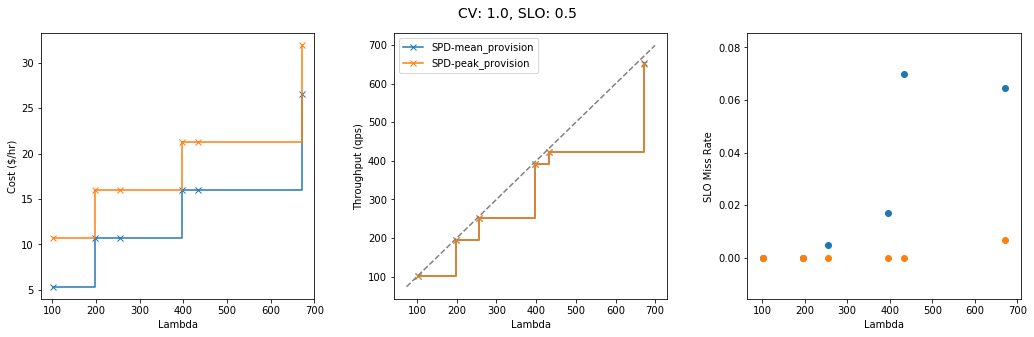

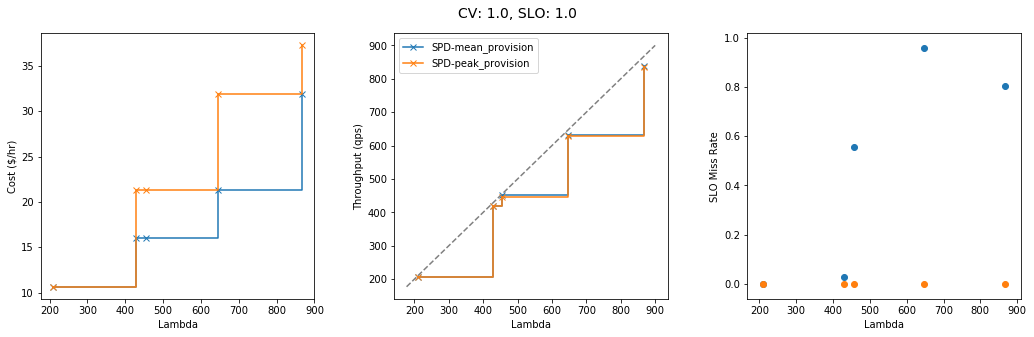

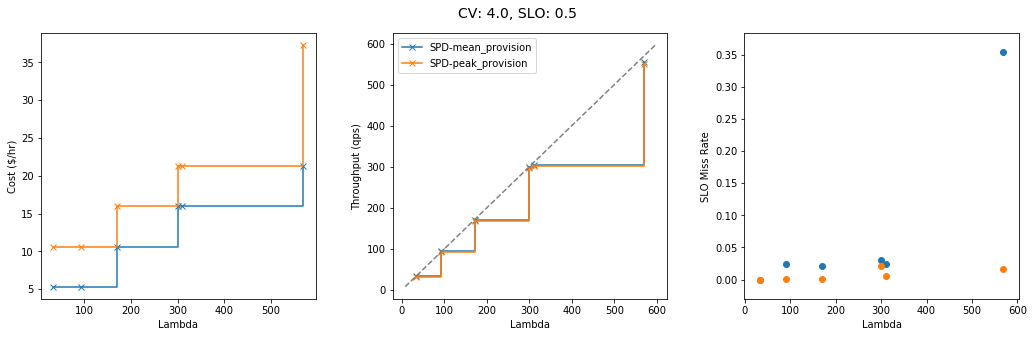

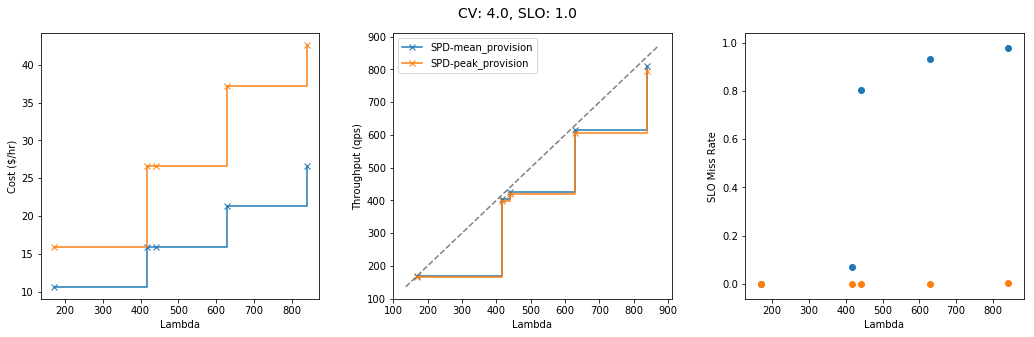

In [95]:
names = pipeline_one_df.name.unique()
colors = sns.color_palette(n_colors=len(names))
cmap = dict(zip(names, colors))

for cv, cv_group in pipeline_one_df.groupby(pipeline_one_df.CV):
    for slo, slo_group in cv_group.groupby(cv_group.slo):
        fig, (ax_cost, ax_thru, ax_slo) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
#         fig, (ax_lam, ax_slo) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        for name, name_group in slo_group.groupby(slo_group.name):
            name_group = name_group.sort_values("lambda")
            ax_cost.step(name_group["lambda"], name_group.cost, "x-", where="post", c=cmap[name], label=name)
            ax_thru.step(name_group["lambda"], name_group.throughput, "x-", where="post", c=cmap[name], label=name)
            ax_slo.scatter(name_group["lambda"], name_group.slo_miss_rate, c=cmap[name], label=name)

#             ax_slo_25.scatter(name_group.lambda, name_group.slo_plus_25_per_miss_rate, c=cmap[name], label=name)
        ax_thru.plot(ax_thru.get_xlim(), ax_thru.get_xlim(), "--", c="grey")
        ax_cost.set_ylabel("Cost ($/hr)")
        ax_cost.set_xlabel("Lambda")
        ax_slo.set_xlabel("Lambda")
        ax_slo.set_ylabel("SLO Miss Rate")
#         ax_slo.set_ylim((-.1,1.2))
        ax_thru.set_xlabel("Lambda")
        ax_thru.set_ylabel("Throughput (qps)")
#         ax_slo.legend(loc=0)

        ax_thru.legend(loc=0)
        fig.suptitle("CV: {cv}, SLO: {slo}".format(cv=cv, slo=slo), fontsize=14)
        plt.tight_layout(pad=3)

            
    

In [ ]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
for cv, cv_group in df.groupby(df.CV):
    for slo, slo_group in cv_group.groupby(cv_group.slo):
        for name, name_group in slo_group.groupby(slo_group.name):
            ax2.scatter(bytes_per_machine(name_group["cost"], name_group["lambda"]*MB_per_query), name_group["slo_miss_rate"], color="red")
ax2.set_ylabel("SLO Miss Rate")
ax2.set_xlabel("Per-node traffic (MBps)")
fig.suptitle("Effect of contention on SLO miss rate")



Inferline/TensorFlow Serving
Machine A: client -----> machine B: [Clipper ---> model 1, model 2, etc.] 


SPD (old):

Machine B: [SPD replica 1, SPD replica 2]

SPD (new):

machine A: client ---> Machine B: [SPD replica 1, SPD replica 2]


-----------------------------------

Dealing with contention:
1) Same utilization factor for all three systems, tuned for Inferline (utilization == 0.7)
2) Utilization factor but tuned for each system independently
3) Profile inferline models under contention and don't apply utilization factor
